# ARIMA 

## Data loading and filteration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose




df = pd.read_csv("./ElectronicsProductsPricingData.csv", encoding='latin1')



df["prices.dateSeen"] = pd.to_datetime(df["prices.dateSeen"], errors='coerce')


# compute a percent‑discount column from the price fields
# discount_percent = ((regular_price - sale_price) / regular_price) * 100
# assume amountMax is the non‑sale price and amountMin the current price;
# guard against division by zero.

df['discount_percent'] = np.where(
    df['prices.amountMax'] > 0,
    100 * (df['prices.amountMax'] - df['prices.amountMin']) / df['prices.amountMax'],
    0
)

df = df[df["prices.dateSeen"].dt.year >= 2017]

df[["discount_percent","prices.amountMax","prices.dateSeen","prices.amountMin"]].head()

/var/folders/st/r78_rxtx0hd_yr_r8qtl08_c0000gn/T/ipykernel_7425/3206310271.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["prices.dateSeen"] = pd.to_datetime(df["prices.dateSeen"], errors='coerce')


,discount_percent,prices.amountMax,prices.dateSeen,prices.amountMin
1,5.811594,69.00,2017-12-14 06:00:00+00:00,64.99
2,0.000000,69.00,2017-09-08 05:00:00+00:00,69.00
3,0.000000,69.99,2017-10-10 05:00:00+00:00,69.99
4,0.000000,66.99,2017-08-28 07:00:00+00:00,66.99
5,0.000000,66.00,2017-10-24 04:00:00+00:00,66.00


## 1. Data preparation

### 1.1 Engineer time features 

### 1.2 Create lag features 

### adf test 

In [2]:
df = df.sort_values("prices.dateSeen")
df = df.set_index("prices.dateSeen")

daily_series = df["discount_percent"].resample("D").mean()
daily_series = daily_series.dropna()

print("Length:", len(daily_series))


result = adfuller(daily_series)

print("ADF Statistic:", result[0])
print("p-value:", result[1])

Length: 202
ADF Statistic: -11.206641812339386
p-value: 2.176503463349421e-20


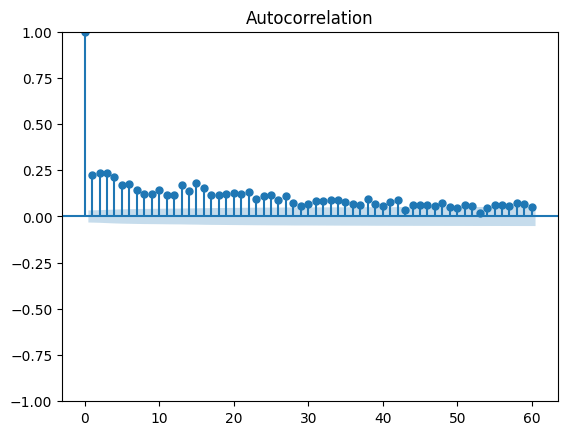

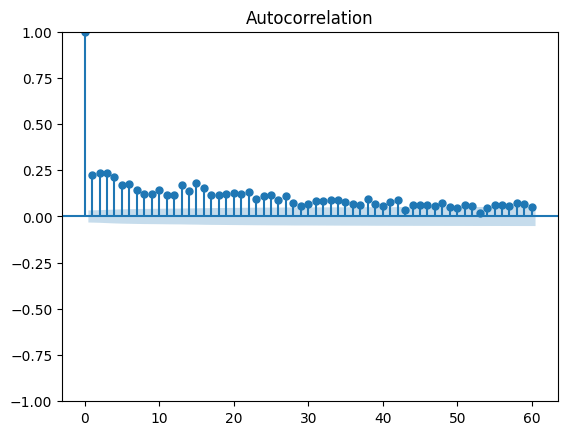

In [3]:
plot_acf(df["discount_percent"].dropna(), lags=60)

#### partial autocoorelation 
 -- here the lag 1 is the one with the highest correlation , whereas other lag 3 is alo , great too , but after lag 6, they are all below the confidence level.

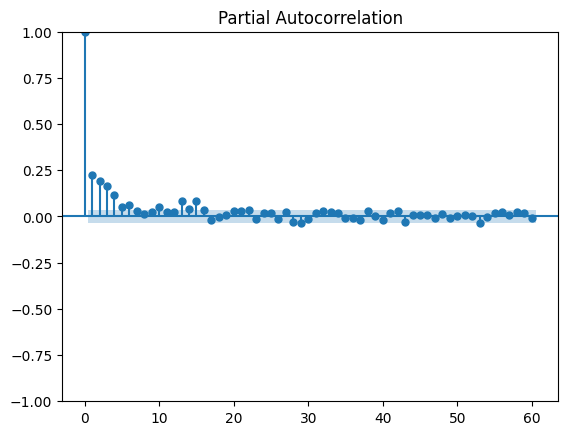

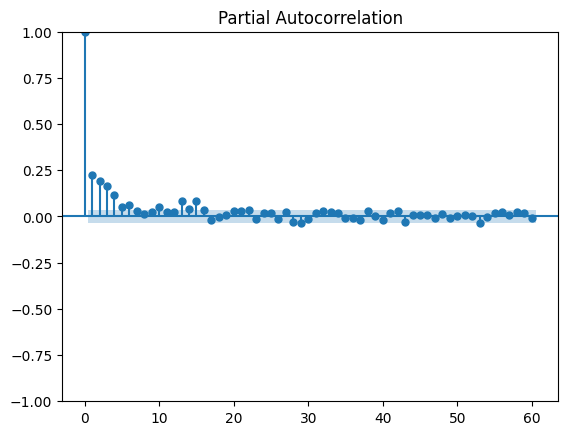

In [4]:
plot_pacf(df["discount_percent"].dropna(), lags=60)

#### lag 1 and lag 3 

In [5]:
series = df["discount_percent"]

lag_df = pd.DataFrame({
    "current": series,
    "lag_1": series.shift(1),
    "lag_3": series.shift(3),
    "lag_14": series.shift(14),
    "lag_30": series.shift(30),
})

In [6]:
lag_df = lag_df.dropna()

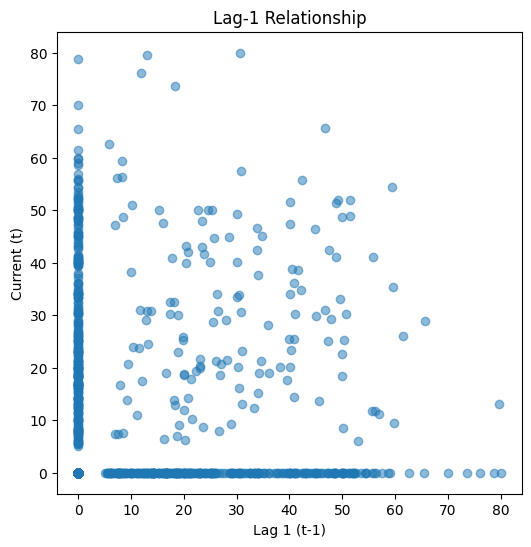

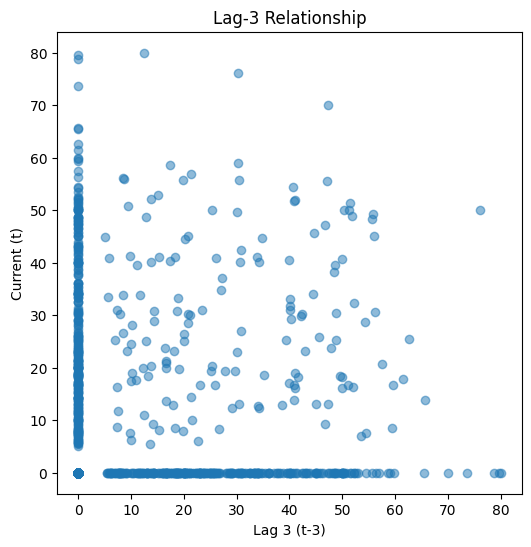

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(lag_df["lag_1"], lag_df["current"], alpha=0.5)
plt.xlabel("Lag 1 (t-1)")
plt.ylabel("Current (t)")
plt.title("Lag-1 Relationship")
plt.show()



plt.figure(figsize=(6, 6))
plt.scatter(lag_df["lag_3"], lag_df["current"], alpha=0.5)
plt.xlabel("Lag 3 (t-3)")
plt.ylabel("Current (t)")
plt.title("Lag-3 Relationship")
plt.show()


#### Monthly & periodic lag analysis

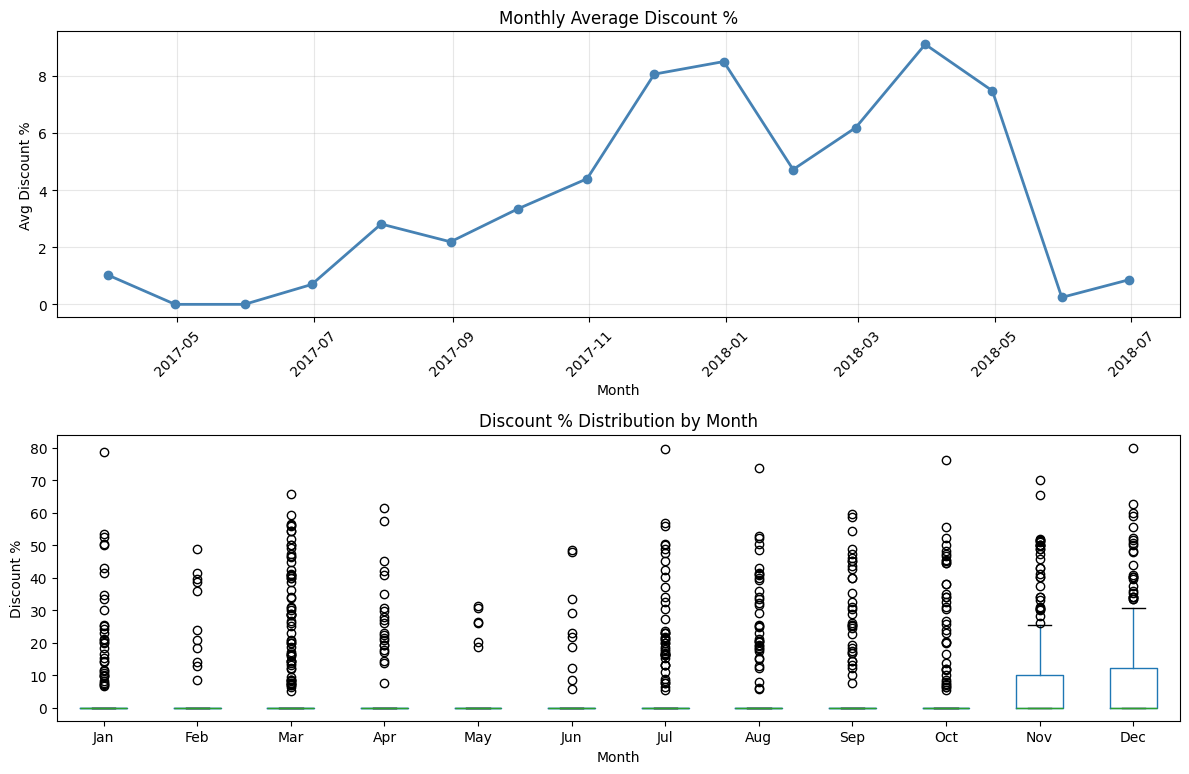

In [8]:
# ── Monthly average discount ──────────────────────────────────────────────
monthly_series = df["discount_percent"].resample("ME").mean()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot monthly mean
axes[0].plot(monthly_series.index, monthly_series.values, marker='o', linewidth=2, color='steelblue')
axes[0].set_title("Monthly Average Discount %")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Avg Discount %")
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Month-of-year box plot (seasonality)
monthly_df = df["discount_percent"].copy().reset_index()
monthly_df.columns = ["date", "discount_percent"]
monthly_df["month"] = monthly_df["date"].dt.month
monthly_df["month_name"] = monthly_df["date"].dt.strftime("%b")
month_order = ["Jan","Feb","Mar","Apr","May","Jun",
               "Jul","Aug","Sep","Oct","Nov","Dec"]
monthly_df["month_name"] = pd.Categorical(monthly_df["month_name"], categories=month_order, ordered=True)
monthly_df_clean = monthly_df.dropna(subset=["month_name"])

monthly_df_clean.boxplot(column="discount_percent", by="month_name",
                          ax=axes[1], grid=False)
axes[1].set_title("Discount % Distribution by Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Discount %")
plt.suptitle("")
plt.tight_layout()
plt.show()


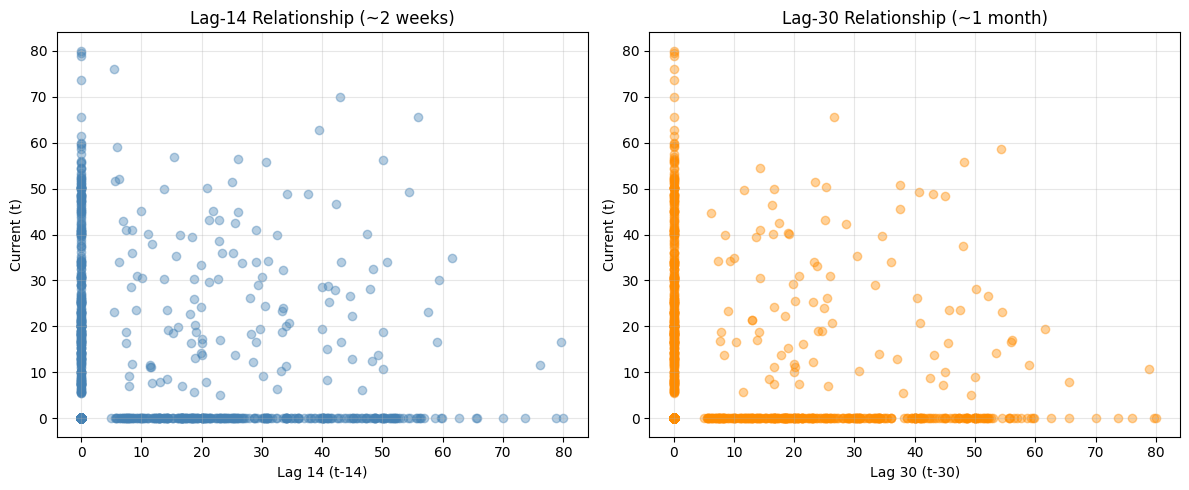

In [9]:
# ── Lag-14 and Lag-30 scatter plots (weekly / monthly lags) ───────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(lag_df["lag_14"], lag_df["current"], alpha=0.4, color='steelblue')
axes[0].set_xlabel("Lag 14 (t-14)")
axes[0].set_ylabel("Current (t)")
axes[0].set_title("Lag-14 Relationship (~2 weeks)")
axes[0].grid(True, alpha=0.3)

axes[1].scatter(lag_df["lag_30"], lag_df["current"], alpha=0.4, color='darkorange')
axes[1].set_xlabel("Lag 30 (t-30)")
axes[1].set_ylabel("Current (t)")
axes[1].set_title("Lag-30 Relationship (~1 month)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


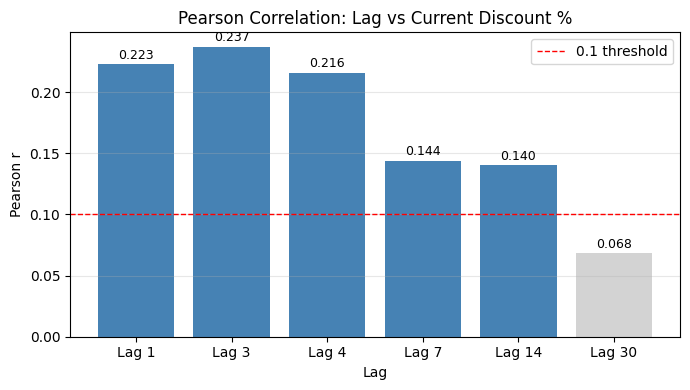

 lag  pearson_r
   1   0.222737
   3   0.237067
   4   0.215901
   7   0.143870
  14   0.140034
  30   0.068086


In [10]:
# ── Lag correlation summary table ─────────────────────────────────────────
# Use lag_df which already has duplicates removed via dropna/shift alignment
lag_df["lag_4"] = lag_df["current"].shift(4)
lag_df["lag_7"] = lag_df["current"].shift(7)
lag_df_clean = lag_df.dropna()

lag_corr = pd.DataFrame({
    "lag": [1, 3, 4, 7, 14, 30],
    "pearson_r": [
        lag_df_clean["lag_1"].corr(lag_df_clean["current"]),
        lag_df_clean["lag_3"].corr(lag_df_clean["current"]),
        lag_df_clean["lag_4"].corr(lag_df_clean["current"]),
        lag_df_clean["lag_7"].corr(lag_df_clean["current"]),
        lag_df_clean["lag_14"].corr(lag_df_clean["current"]),
        lag_df_clean["lag_30"].corr(lag_df_clean["current"]),
    ]
})

fig, ax = plt.subplots(figsize=(7, 4))
colors = ['steelblue' if r > 0.1 else 'lightgray' for r in lag_corr["pearson_r"]]
bars = ax.bar([f"Lag {l}" for l in lag_corr["lag"]], lag_corr["pearson_r"], color=colors)
ax.axhline(0.1, color='red', linestyle='--', linewidth=1, label='0.1 threshold')
ax.set_title("Pearson Correlation: Lag vs Current Discount %")
ax.set_ylabel("Pearson r")
ax.set_xlabel("Lag")
ax.legend()
ax.grid(True, axis='y', alpha=0.3)
for bar, val in zip(bars, lag_corr["pearson_r"]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f"{val:.3f}", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

print(lag_corr.to_string(index=False))


### 1.3 Handle =% discount - build two stage model

### Train/test split: 2017 = train, 2018 = test